<a href="https://colab.research.google.com/github/romerofernandes/class_fault/blob/main/class_fault.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importações

###Bibliotecas

In [41]:
#Analise de dados
import pandas as pd
import numpy as np

In [42]:
#Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [43]:
#Modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [44]:
! pip install scikit-optimize

In [45]:
#Otimização de hiperparametros 
#Necessario instalar scikit-optimize: ! pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Integer

In [46]:
#Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [47]:
#Análise dos modelos
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

###Dados

####Dataset para treinamento, validação e teste

O arquivo 'detect_dataset.csv' é composto por medições de corrente (Ia, Ib, Ic), medições de tensão (Va, Vb, Vc) e uma coluna com a classificação (0 - not fault, 1 - fault).

In [48]:
#dataset para treino, validação e teste
df_fault = pd.read_csv('/content/detect_dataset.csv')

In [49]:
df_fault.head()

,Output (S),Ia,Ib,Ic,Va,Vb,Vc,Unnamed: 7,Unnamed: 8
0,0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431,NaN,NaN
1,0,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202,NaN,NaN
2,0,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251,NaN,NaN
3,0,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963,NaN,NaN
4,0,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050,NaN,NaN


In [50]:
#Renomeando a coluna com a classe de interesse
df_fault.rename(columns={'Output (S)': 'fault'}, inplace=True)

#Removendo as colunas sem dados e alterando a ordem das restantes
df_fault = df_fault[['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'fault']]

In [51]:
df_fault.head()

,Ia,Ib,Ic,Va,Vb,Vc,fault
0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431,0
1,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202,0
2,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251,0
3,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963,0
4,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050,0


####Dataset para teste robusto

O arquivo 'classData.csv' foi construído para servir de base para um sistema classificador multiclasse no qual iria identificar o tipo de falta:

* Fase-Neutro
* Fase-Fase
* Fase-Fase-Neutro
* Fase-Fase-Fase
* Fase-Fase-Fase-Neutro
* Sem curto

Neste trabalho ele será usado como um dataset de teste. Para isso será transformado para uma estrutura semelhante à que tem o 'detect_dataset.csv'.

In [52]:
#dataset para teste
df_fault_test = pd.read_csv('/content/classData.csv')

In [53]:
df_fault_test.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


In [54]:
#Criando uma coluna para concatenar as colunas G, C, B e A
df_fault_test['cod_fault'] = df_fault_test.G.astype(str) + df_fault_test.C.astype(str) \
                              + df_fault_test.B.astype(str) + df_fault_test.A.astype(str)

A coluna 'cod_fault' conterá o código do tipo de falta:

0000 - No Fault

1001 - LG fault (Fase-Neutro)

0011 - LL fault (Fase-Fase)

1011 - LLG Fault (Fase-Fase-Neutro)

0111 - LLL Fault(Fase-Fase-Fase)

1111 - LLLG fault( Fase-Fase-Fase-Neutro)

In [55]:
#Criando a coluna 'fault' contendo a classificação de cada registro (0 - no fault, 1 - fault)
df_fault_test['fault'] = df_fault_test.apply(lambda x: 0 if x.cod_fault == '0000' else 1, axis=1)

In [56]:
df_fault_test.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,cod_fault,fault
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001,1
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001,1
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001,1
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001,1
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001,1


##Análise dos dados

####Qualidade dos registros

Vamos verificar tratar os dados faltantes caso hajam e excluir as linhas duplicadas caso existam.

In [ ]:
#Verificando dados faltantes
df_fault.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12001 entries, 0 to 12000
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ia      12001 non-null  float64
 1   Ib      12001 non-null  float64
 2   Ic      12001 non-null  float64
 3   Va      12001 non-null  float64
 4   Vb      12001 non-null  float64
 5   Vc      12001 non-null  float64
 6   fault   12001 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 656.4 KB


In [ ]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_fault.duplicated().sum()}")

Valores duplicados: 0


####Analisando o conteúdo dos registros

Vamos verificar o balanceamento das classes (fault e not fault), a distribuição e as relações de cada feature.

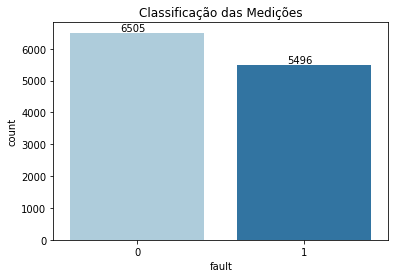

In [ ]:
#Utilizaremos a visualização countplot para verificar o balanceamento das classes
ax = sns.countplot(x=df_fault['fault'], palette="Paired")

for p, label in zip(ax.patches, df_fault["fault"].value_counts().values):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()*1.007), ha = 'center')

plt.title("Classificação das Medições")
plt.show()

O dataset foi construído com já levando em consideração o balanceamento. Verificaremos então a distribuição de cada feature.

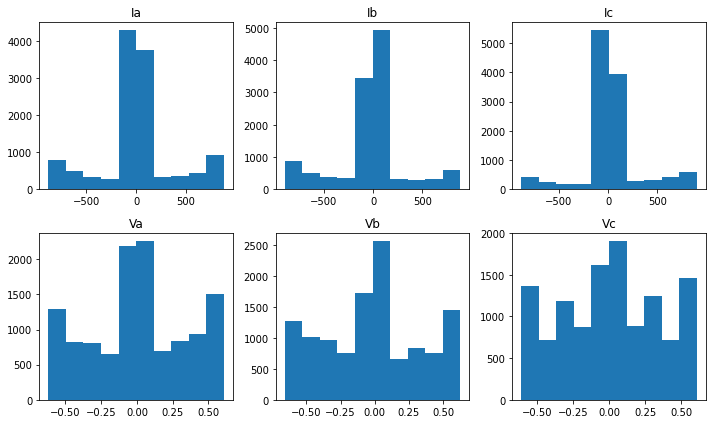

In [ ]:
#Plot do histograma de cada coluna
fig, axs = plt.subplots(2, 3,figsize=(10,6))
fig.tight_layout()
columns = df_fault.columns[:6]
count = 0
for j in range(2):
  for i in range(3):
    axs[j, i].hist(x=df_fault[columns[count]])
    axs[j, i].set_title(columns[count])
    plt.tight_layout()
    count +=1

Todas as features possuem uma distribuição aproximadamente Normal. Por fim, verificaremos o relacionamento entre as features.

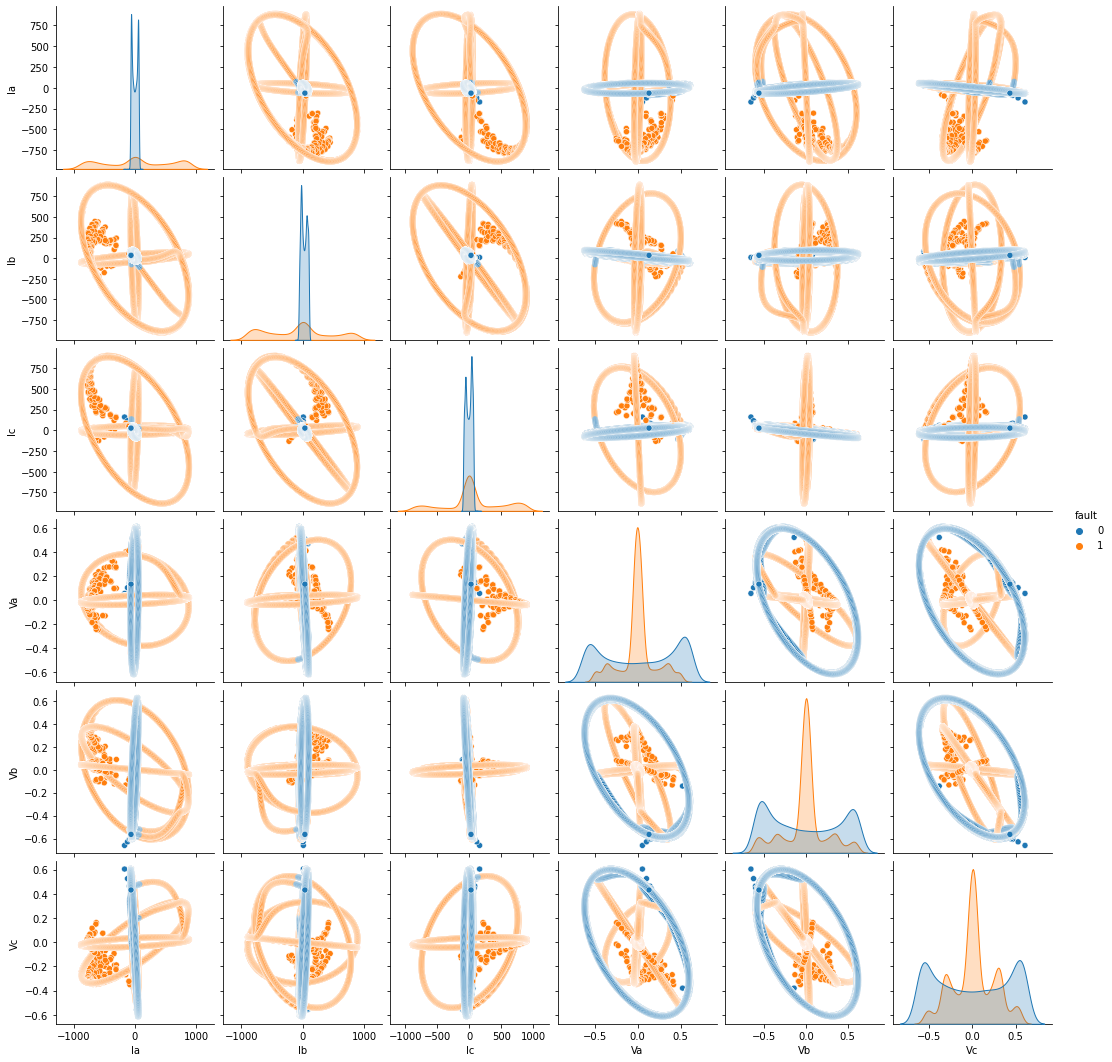

In [ ]:
#Plot pairplot
sns.pairplot(df_fault,hue='fault')
plt.show()

Fica claro pelo grafico acima que estamos trabalhando com um problema não linear.

##Treinamento e teste

###Preparação

In [57]:
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
X = df_fault[features]
y = df_fault['fault']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

###Modelos

####Support Vector Machines

In [59]:
# Conjunto de valores para os Hiperparametros
params = {
         'C': (1e-0, 1e+3, 'log-uniform'),
         'gamma': (1e-2, 1e+1, 'log-uniform'),
         }

In [60]:
%%time
# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:
BS_SVC = BayesSearchCV(estimator = SVC(),
                       search_spaces = params,
                       scoring='recall',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:
BS_SVC.fit(X_test,y_test)


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CPU times: user 2min 1s, sys: 7.91 s, total: 2min 9s
Wall time: 2min 5s


In [61]:
#Vamos ver informações relevantes:
print('C: {}'.format(BS_SVC.best_params_['C']))
print('gamma: {}'.format(BS_SVC.best_params_['gamma']))
print('Best Score: {}'.format(BS_SVC.best_score_))

C: 17.257565936464992
gamma: 0.5646310499409866
Best Score: 0.9963235294117647


In [62]:
classif_fault_SVM = SVC(C=17.258, gamma=0.565)

In [63]:
classif_fault_SVM.fit(X_train, y_train)

SVC(C=17.258, gamma=0.565)

In [64]:
metricas = cross_validate(classif_fault_SVM, X_test, y_test, cv=10, scoring=['recall', 'f1'])
print("Recall Score medio:", np.mean(metricas['test_recall']))
print("f1 Score medio:", np.mean(metricas['test_f1']))

Recall Score medio: 0.9963235294117647
f1 Score medio: 0.9183643534500222


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


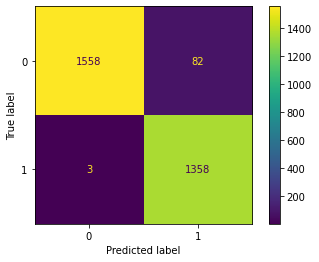

In [65]:
metrics.plot_confusion_matrix(classif_fault_SVM,X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


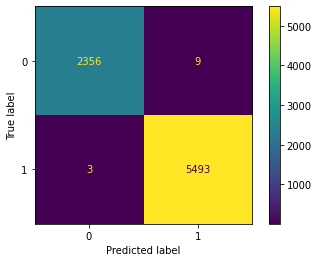

In [ ]:
metrics.plot_confusion_matrix(classif_fault_SVM, df_fault_test[features], df_fault_test['fault'])

####Random Forest

In [67]:
# define search space 
params = {
    "n_estimators": (1, 10000),
    "max_depth": (1, 10),
    "max_features":(1,6),
    "criterion": ["gini", "entropy"],
}

In [40]:
# Definindo o Random Search CV. Vamos fornecer o argumento n_iter, que fala quantas configurações de hparams testar:
BS_SVC = BayesSearchCV(estimator = RandomForestClassifier(),
                       search_spaces = params,
                       scoring='recall',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por GridSearch para os dados de cancer de mama:
BS_SVC.fit(X_test,y_test)

KeyboardInterrupt: ignored

In [ ]:
'''
#Vamos ver informações relevantes:
print('n_estimators: {}'.format(BS_SVC.best_params_['n_estimators']))
print('max_depth: {}'.format(BS_SVC.best_params_['max_depth']))
print('criterion: {}'.format(BS_SVC.best_params_['criterion']))
print('Best Score: {}'.format(BS_SVC.best_score_))
'''
'''
n_estimators: 3
max_depth: 9
criterion: gini
Best Score: 0.9904519106912837
'''

n_estimators: 3
max_depth: 9
criterion: gini
Best Score: 0.9904519106912837


In [ ]:
classif_fault_RF = RandomForestClassifier(n_estimators=3, max_depth=9)

In [ ]:
classif_fault_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, n_estimators=3)

In [ ]:
recall_scores = cross_validate(classif_fault_RF, X_test, y_test, cv=10, scoring=['recall', 'f1'])
print("Recall Score medio:", np.mean(recall_scores['test_recall']))
print("f1 Score medio:", np.mean(recall_scores['test_f1']))

Recall Score medio: 0.9882513954486903
f1 Score medio: 0.9911620465802329


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


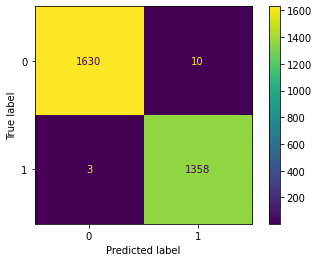

In [ ]:
metrics.plot_confusion_matrix(classif_fault_RF,X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


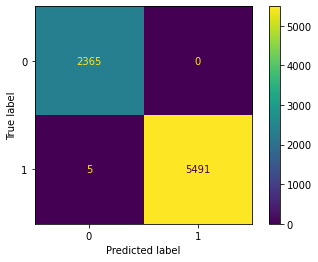

In [ ]:
metrics.plot_confusion_matrix(classif_fault_RF, df_fault_test[features], df_fault_test['fault'])

####Decision Tree Model

In [ ]:
# define search space 
params = {
    "min_samples_leaf": (1,100),
    "max_depth": (1, 20),
    "criterion": ["gini", "entropy"],
}

In [ ]:
# Definindo o Random Search CV. Vamos fornecer o argumento n_iter, que fala quantas configurações de hparams testar:
BS_SVC = BayesSearchCV(estimator = DecisionTreeClassifier(),
                       search_spaces = params,
                       scoring='recall',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por GridSearch para os dados de cancer de mama:
BS_SVC.fit(X_test,y_test)

BayesSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=20,
              random_state=123, scoring='recall',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': (1, 20),
                             'min_samples_leaf': (1, 100)})

In [ ]:
#Vamos ver informações relevantes:
print('min_samples_leaf: {}'.format(BS_SVC.best_params_['min_samples_leaf']))
print('max_depth: {}'.format(BS_SVC.best_params_['max_depth']))
print('criterion: {}'.format(BS_SVC.best_params_['criterion']))
print('Best Score: {}'.format(BS_SVC.best_score_))

'''
min_samples_leaf: 1
max_depth: 17
criterion: gini
Best Score: 0.9904519106912838
'''

min_samples_leaf: 1
max_depth: 17
criterion: gini
Best Score: 0.9904519106912838


In [ ]:
classif_fault_DT = DecisionTreeClassifier(max_depth=17)

In [ ]:
classif_fault_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=17)

In [ ]:
recall_scores = cross_validate(classif_fault_DT, X_test, y_test, cv=10, scoring=['recall', 'f1'])
print("Recall Score medio:", np.mean(recall_scores['test_recall']))
print("f1 Score medio:", np.mean(recall_scores['test_f1']))

Recall Score medio: 0.9889813224559896
f1 Score medio: 0.9904325357306847


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


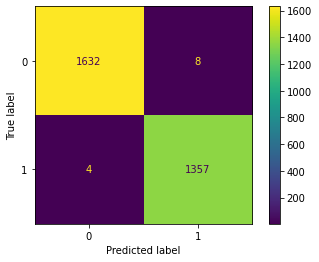

In [ ]:
metrics.plot_confusion_matrix(classif_fault_DT,X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


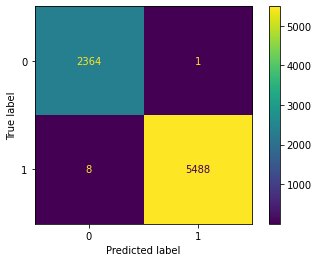

In [ ]:
metrics.plot_confusion_matrix(classif_fault_DT, df_fault_test[features], df_fault_test['fault'])

####XGBoost Classifier

In [ ]:
# define search space 
params = {
    "eta": (0,1),
    "gamma": (0, 1000),
    "max_depth": (1, 20),
    "objective": ['binary:logistic', 'binary:logitraw', 'binary:hinge']
}

In [ ]:
# Definindo o Random Search CV. Vamos fornecer o argumento n_iter, que fala quantas configurações de hparams testar:
BS_SVC = BayesSearchCV(estimator = XGBClassifier(),
                       search_spaces = params,
                       scoring='recall',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por GridSearch para os dados de cancer de mama:
BS_SVC.fit(X_test,y_test)

BayesSearchCV(cv=10, estimator=XGBClassifier(), n_iter=20, random_state=123,
              scoring='recall',
              search_spaces={'eta': (0, 1), 'gamma': (0, 1000),
                             'max_depth': (1, 20),
                             'objective': ['binary:logistic', 'binary:logitraw',
                                           'binary:hinge']})

In [ ]:
#Vamos ver informações relevantes:
print('eta: {}'.format(BS_SVC.best_params_['eta']))
print('gamma: {}'.format(BS_SVC.best_params_['gamma']))
print('max_depth: {}'.format(BS_SVC.best_params_['max_depth']))
print('objective: {}'.format(BS_SVC.best_params_['objective']))
print('Best Score: {}'.format(BS_SVC.best_score_))

'''
eta: 1
gamma: 0
max_depth: 20
objective: binary:logistic
Best Score: 0.992657793044225
'''

eta: 1
gamma: 0
max_depth: 20
objective: binary:logistic
Best Score: 0.992657793044225


In [ ]:
classif_fault_XGB = XGBClassifier(eta=1, max_depth=20, objective='binary:logistic' )

In [ ]:
classif_fault_XGB.fit(X_train, y_train)

XGBClassifier(eta=1, max_depth=20)

In [ ]:
recall_scores = cross_validate(classif_fault_XGB, X_test, y_test, cv=10, scoring=['recall', 'f1'])
print("Recall Score medio:", np.mean(recall_scores['test_recall']))
print("f1 Score medio:", np.mean(recall_scores['test_f1']))

Recall Score medio: 0.992657793044225
f1 Score medio: 0.9937591986866099


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


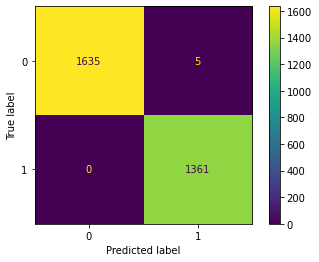

In [ ]:
metrics.plot_confusion_matrix(classif_fault_XGB,X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


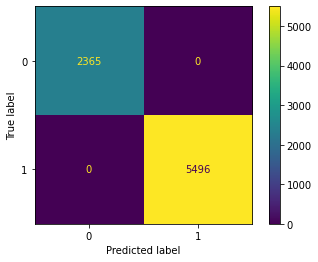

In [ ]:
metrics.plot_confusion_matrix(classif_fault_XGB, df_fault_test[features], df_fault_test['fault'])